QuantumNativeDojo/5章変分量子回路に基づくアルゴリズム/5-2[1]を参考にして,勾配降下法による量子回路の学習の実装を行った.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qulacs import QuantumState
from qulacs import Observable
from qulacs import QuantumCircuit
from qulacs import ParametricQuantumCircuit

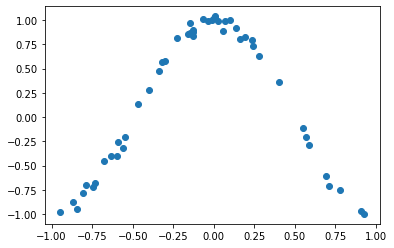

In [2]:
########  パラメータ  #############
nqubit = 3 ## qubitの数
c_depth = 3 ## circuitの深さ
time_step = 0.77  ## ランダムハミルトニアンによる時間発展の経過時間

## [x_min, x_max]のうち, ランダムにnum_x_train個の点をとって教師データとする.
x_min = - 1.; x_max = 1.;
num_x_train = 50

## 学習したい1変数関数
func_to_learn = lambda x: np.cos(x*np.pi)

## 乱数のシード
random_seed = 2
## 乱数発生器の初期化
np.random.seed(random_seed)

#### 教師データを準備
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

# Parametrized Quantum Circuit の作成
量子回路の作成は[2]を参考にした.

各量子ビットに作用するパラメトリックな回転ゲート層とエンタングルメントを生成するCZゲート層の組を`c_depth`分積み重ねる.

[1]では１つの回転ゲート層の各量子ビットにRX,RY,RXを通しているが、ここではRXゲートのみとなっている.(Observableとの組み合わせ次第で,RXゲートだけではsin波データの学習は失敗する. cf `X-Y decomposition of a single qbit gate`)

In [3]:
U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    for i in range(nqubit):
        angle = 2.0*np.pi*np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        U_out.add_CZ_gate(i%nqubit,(i+1)%nqubit) # entangler layer
for i in range(nqubit):
    angle = 2.0*np.pi*np.random.rand()
    U_out.add_parametric_RX_gate(i,angle)

# 予測モデルの作成
[1]を参考に予測モデルを作成した.

`U_encode_gate`は教師データを高次元データにエンコードするゲートである.

`encode_state`はミニバッチ学習を見据え教師データをまとめてエンコードする関数である.

In [4]:
def U_encode_gate(x):
    U = QuantumCircuit(nqubit)
    
    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)
    
    for i in range(nqubit):
        U.add_RY_gate(i,angle_y)
        U.add_RZ_gate(i,angle_z)
        
    return U

def encode_state(x):
    encode_state_list = []
    state = QuantumState(nqubit)
    for i in range(len(x)):
        state.set_zero_state()
        u = U_encode_gate(x[i])
        u.update_quantum_state(state)
        encode_state_list.append(state.copy())
        
    return encode_state_list

from qulacs import Observable
obs = Observable(nqubit)
obs.add_operator(2., 'Z 0')

def pred(x, u):
    state_list = encode_state(x)
    res_list = []
    for i in range(len(state_list)):
        u.update_quantum_state(state_list[i])
        res = obs.get_expectation_value(state_list[i])
        res_list.append(res)
    return np.array(res_list)

# コスト関数/勾配
コスト関数として平均自乗誤差を用いる.平均自乗誤差のパラメータ微分のやり方は[3]に詳しい.

In [5]:
def set_U(theta, u):
    parameter_count = u.get_parameter_count()
    for i in range(parameter_count):
        u.set_parameter(i,theta[i])
    return u

def cost_func(x,theta,u):
    set_U(theta, u)
    y_pred = pred(x,u)
    L = ((y_pred - y_train)**2).mean()
    
    return L
    
def pred_grad(x,theta,u):
    batch_size = len(x)
    theta_plus = np.array([theta.copy() + np.eye(len(theta))[i]*np.pi/2. for i in range(len(theta))])
    theta_minus = np.array([theta.copy() - np.eye(len(theta))[i]*np.pi/2. for i in range(len(theta))])
    grad = []
    u_plus = u.copy()
    u_minus = u.copy()
    
    for i in range(len(theta)):
        set_U(theta_plus[i],u_plus)
        set_U(theta_minus[i],u_minus)
    
        grad.append(((pred(x,u_plus)-pred(x,u_minus))/2.)/batch_size)
    return np.array(grad)

def cost_func_grad(x,y,theta,u):
    b_gr = pred_grad(x,theta,u)
    set_U(theta,u)
    cf_grad = np.dot(b_gr,(pred(x,u)-y))
    return np.array(cf_grad)

In [6]:
parameter_count = U_out.get_parameter_count()
theta_init = np.array([U_out.get_parameter(ind) for ind in range(parameter_count)])
cost_func(x_train,theta_init,U_out)

2.058682814287808

In [7]:
theta = theta_init.copy()
learning_rate = 0.1
for i in range(1000):
    theta = theta -learning_rate*cost_func_grad(x_train,y_train,theta,U_out)
    if (i % 100) == 0:
        print(cost_func(x_train,theta,U_out))

1.6012996205503598
0.12917904935631336
0.11835762771148522
0.11467143859752485
0.1121493981681858
0.10877573592727713
0.10359771917361686
0.09630285580996595
0.08723454904179725
0.07770947365591838


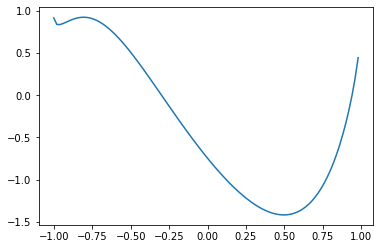

In [9]:
# パラメータthetaの初期値のもとでのグラフ
xlist = np.arange(x_min, x_max, 0.02)
set_U(theta_init,U_out)
y_init = pred(xlist, U_out)
plt.plot(xlist, y_init)

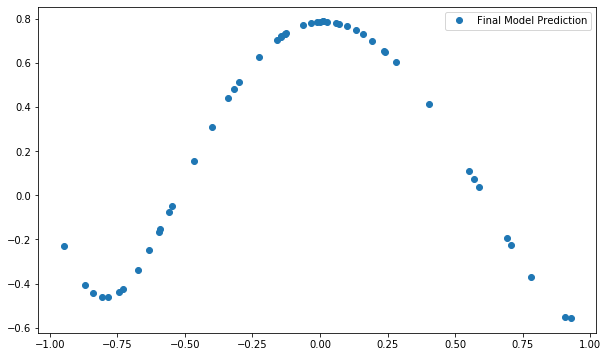

In [11]:
plt.figure(figsize=(10,6))
x_list = np.arange(x_min,x_max,0.02)
set_U(theta,U_out)
y_pred = pred(x_train, U_out)
plt.plot(x_train, y_pred, "o",label='Final Model Prediction')

plt.legend()
plt.show()

# 参考文献
[1] [Quantum Native Dojo(変分量子回路に基づくアルゴリズム)](https://dojo.qulacs.org/ja/latest/notebooks/5.2_Quantum_Circuit_Learning.html)

[2] C. Zoufal,A. Lucchi, and S. Woerner, "Quantum Generative Adversarial Networksfor Learning and Loading Random Distributions"

[3] K. Mitarai, M. Negoro, M. Kitagawa, and K. Fujii, “Quantum circuit learning”, [Phys. Rev. A 98, 032309 (2018)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.98.032309), arXiv版：https://arxiv.org/abs/1803.00745  